In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection"


unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/dataset.zip, /content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/dataset.zip.zip or /content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/dataset.zip.ZIP.


In [4]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_data_path = '/content/drive/MyDrive/Colab notebooks/dataset/Training'

filepath = []
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
  f_path = os.path.join(train_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)

    for file in filelists:
      filepath.append(os.path.join(f_path, file))
      labels.append(fold)

#concat data paths with labels
Fseries = pd.Series(filepath, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries ,Lseries] , axis = 1)

In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/Colab notebooks/dataset...,pituitary
1,/content/drive/MyDrive/Colab notebooks/dataset...,pituitary
2,/content/drive/MyDrive/Colab notebooks/dataset...,pituitary
3,/content/drive/MyDrive/Colab notebooks/dataset...,pituitary
4,/content/drive/MyDrive/Colab notebooks/dataset...,pituitary
...,...,...
5707,/content/drive/MyDrive/Colab notebooks/dataset...,meningioma
5708,/content/drive/MyDrive/Colab notebooks/dataset...,meningioma
5709,/content/drive/MyDrive/Colab notebooks/dataset...,meningioma
5710,/content/drive/MyDrive/Colab notebooks/dataset...,meningioma


In [9]:
test_data_path = '/content/drive/MyDrive/Colab notebooks/dataset/Testing'

filepath = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
  f_path = os.path.join(test_data_path, fold)
  if os.path.isdir(f_path):
    filelists = os.listdir(f_path)

    for file in filelists:
      filepath.append(os.path.join(f_path, file))
      labels.append(fold)

#concat data paths with labels
Fseries = pd.Series(filepath, name='filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries ,Lseries] , axis = 1)

In [10]:
valid, test = train_test_split(test_df, test_size=0.5,shuffle=True, random_state=42)

In [11]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

# Split train_df into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


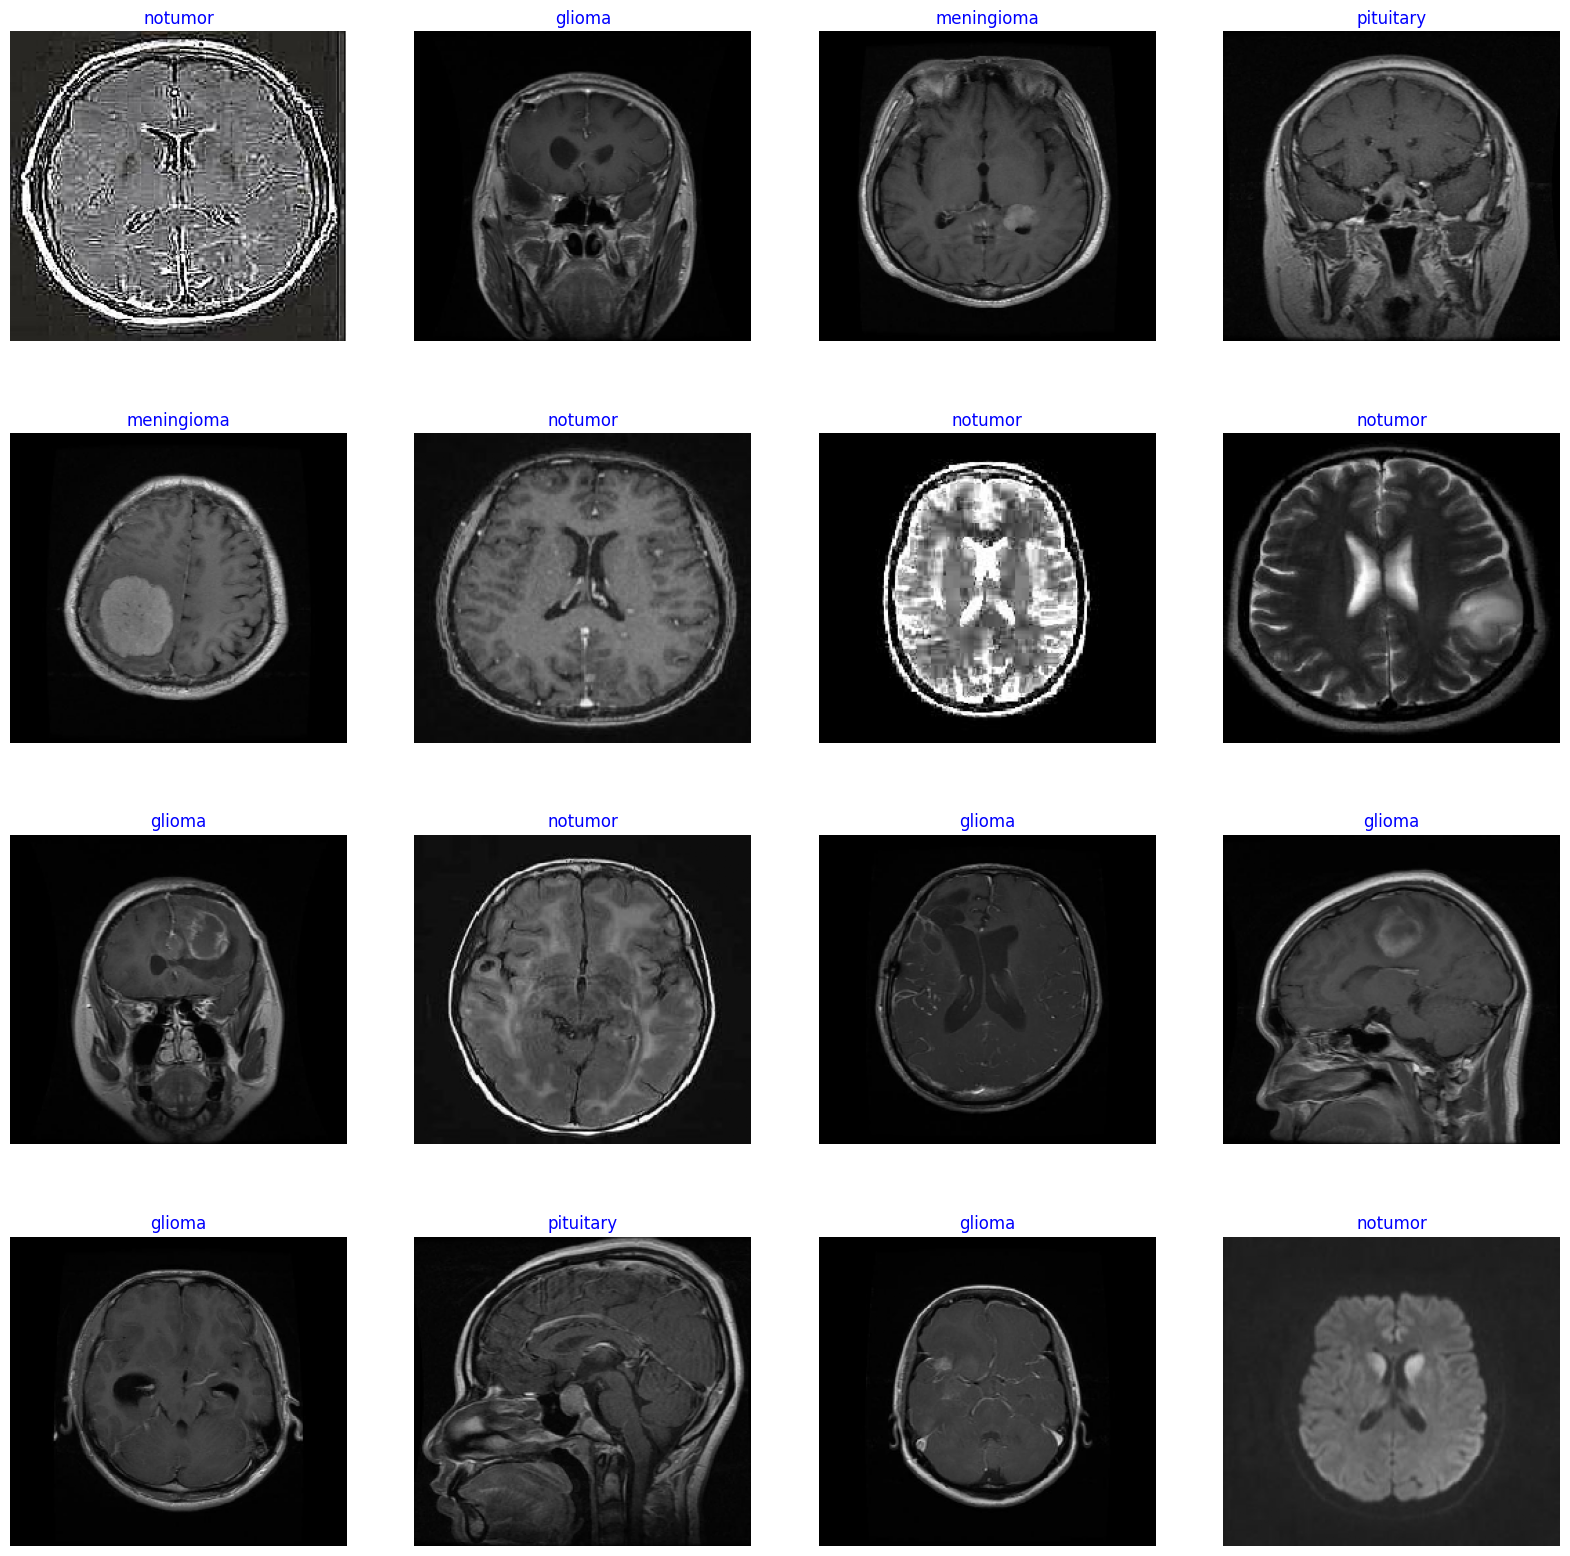

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color = 'blue' , fontsize= 12)
  plt.axis('off')

plt.show()

In [13]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

TRAINING MODELS

In [14]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs=Epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=True
)

Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 1402s 5s/step - accuracy: 0.6076 - loss: 10.9524 - val_accuracy: 0.5809 - val_loss: 5.9195
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.5106 - loss: 5.4708 - val_accuracy: 0.4409 - val_loss: 4.2187
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.5251 - loss: 3.8991 - val_accuracy: 0.6185 - val_loss: 3.0214
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - accuracy: 0.5471 - loss: 2.8348 - val_accuracy: 0.5748 - val_loss: 2.2404
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.5994 - loss: 2.1337 - val_accuracy: 0.8478 - val_loss: 1.6742
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.7514 - loss: 1.6448 - val_accuracy: 0.9248 - val_loss: 1.2516
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - accuracy: 0.8100 - loss: 1.3000 - val_accuracy: 0.9300 - val_loss: 1.0058
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.8672 - loss: 1

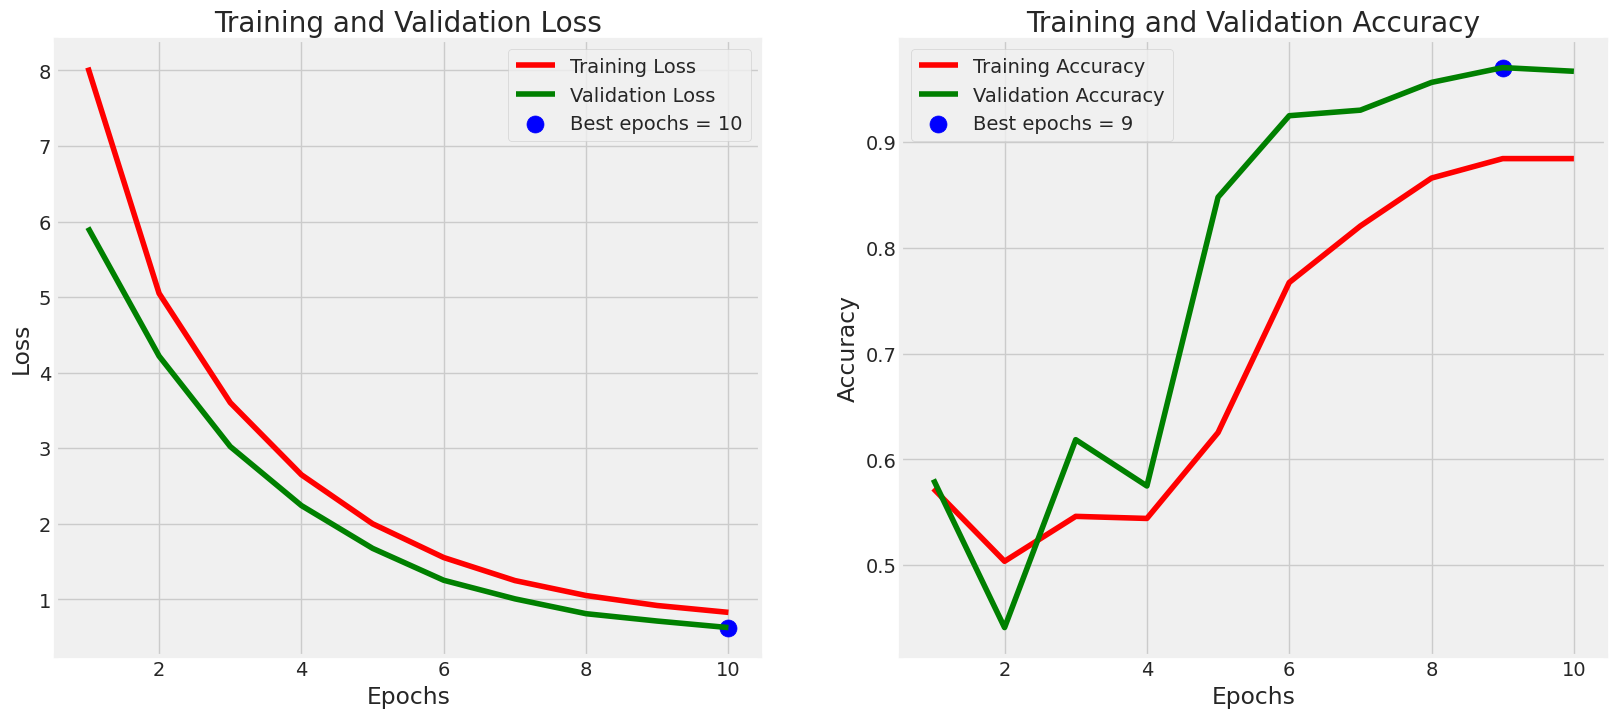

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9909 - loss: 0.5934
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9575 - loss: 0.6392
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.9908 - loss: 0.5639
Train Loss:  0.6009045243263245
Train Accuracy:  0.984375
--------------------
Validation Loss:  0.6374683976173401
Validation Accuracy:  0.953125
--------------------
Test Loss:  0.5786203742027283
Test Accuracy:  0.98046875


In [18]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step


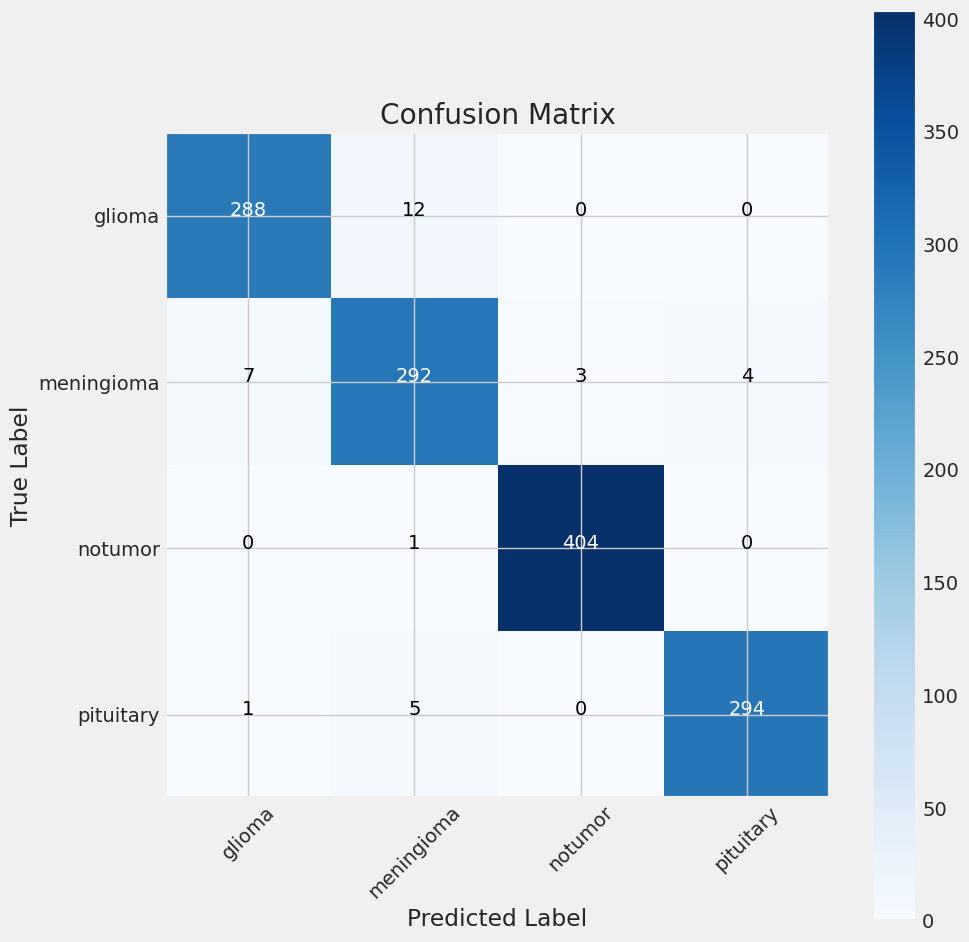

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [23]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.97       300
  meningioma       0.94      0.95      0.95       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [20]:
model.save("model.h5")

In [21]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [22]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
gambar = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab notebooks/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [34]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [35]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


In [36]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [37]:
print(predicted_class)

[0]


In [38]:
names = [classes[i] for i in predicted_class]
print(names)

['glioma']
